# Transfer Learning

... following https://keras.io/guides/transfer_learning/

__Also interesting: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html and https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/__

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [67]:
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

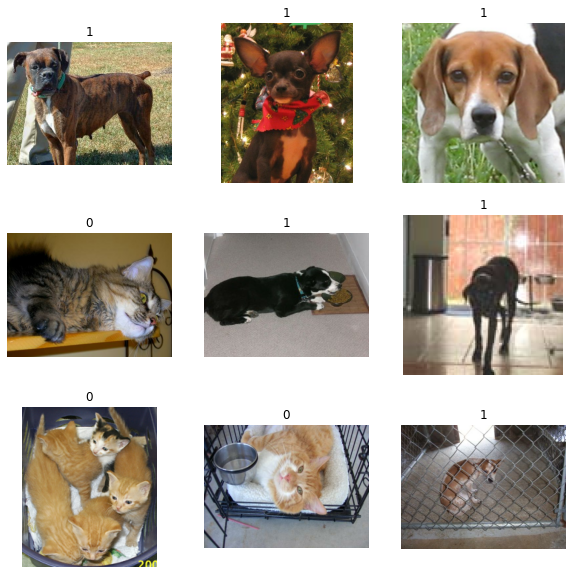

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [68]:
size = (150, 150)
BFS = 10
BTS = 32

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

train_ds = train_ds.cache().batch(BTS).prefetch(buffer_size=BFS)
validation_ds = validation_ds.cache().batch(BTS).prefetch(buffer_size=BFS)
test_ds = test_ds.cache().batch(BTS).prefetch(buffer_size=BFS)

In [69]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

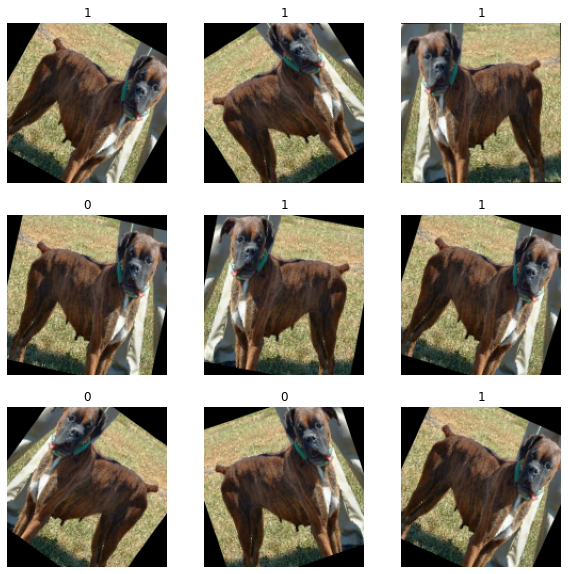

In [6]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [179]:
base_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)

# Pre-trained Xception weights requires that input be normalized from (0, 255) to a range (-1., +1.), 
# the normalization layer does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode when we unfreeze the base 
# model for fine-tuning, so we make sure that the base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049

In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 519s 2s/step - loss: 0.1849 - binary_accuracy: 0.9154 - val_loss: 0.0897 - val_binary_accuracy: 0.9686
Epoch 2/20
291/291 [==============================] - 445s 2s/step - loss: 0.1374 - binary_accuracy: 0.9375 - val_loss: 0.0922 - val_binary_accuracy: 0.9695
Epoch 3/20
291/291 [==============================] - 441s 2s/step - loss: 0.1293 - binary_accuracy: 0.9426 - val_loss: 0.0772 - val_binary_accuracy: 0.9721
Epoch 4/20
291/291 [==============================] - 454s 2s/step - loss: 0.1236 - binary_accuracy: 0.9488 - val_loss: 0.0844 - val_binary_accuracy: 0.9690
Epoch 5/20
291/291 [==============================] - 478s 2s/step - loss: 0.1246 - binary_accuracy: 0.9453 - val_loss: 0.0734 - val_binary_accuracy: 0.9729
Epoch 6/20
291/291 [==============================] - 507s 2s/step - loss: 0.1195 - binary_accuracy: 0.9476 - val_loss: 0.0878 - val_binary_accuracy: 0.9682
Epoch 7/20
291/291 [==============================] - 519s

In [ ]:
model.save('keras_TL_cat_dog')
loaded_model = load_model('keras_TL_cat_dog')

In [76]:
# Unfreeze the base_model. Note that it keeps running in inference mode since we passed `training=False` 
# when calling it. This means that the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.SGD(1e-5),  # Adam, Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [77]:
from tensorflow.keras.models import save_model, load_model
save_model(model, 'fine_tuned_keras_TL_cat_dog-SGD')

INFO:tensorflow:Assets written to: fine_tuned_keras_TL_cat_dog-SGD/assets


INFO:tensorflow:Assets written to: fine_tuned_keras_TL_cat_dog-SGD/assets


In [84]:
# model.evaluate(test_ds): [0.07796552032232285, 0.9797936081886292]
# loaded_model.evaluate(test_ds): [0.08429354429244995, 0.9720550179481506]

73/73 [==============================] - 96s 1s/step - loss: 0.0843 - binary_accuracy: 0.9721


[0.08429354429244995, 0.9720550179481506]

In [ ]:
model = load_model(filepath, compile = True)

In [152]:
def esc(code):
     return f'\033[{code}m'
    
funcs = {
    "relu": tf.nn.relu,
    "relu6": tf.nn.relu6,
    "selu": tf.nn.selu,
    "elu": tf.nn.elu,
    "swish": tf.nn.swish,
    "leaky-relu": tf.nn.leaky_relu,
    "sigmoid": tf.nn.sigmoid,
    "softsign": tf.nn.softsign,
    # not applicable: 
    # "crelu": tf.nn.crelu,
    # "softmax": tf.nn.softmax,
    # "log_softmax": tf.nn.log_softmax,
}

image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict(image_batch).flatten()
predictions = tf.convert_to_tensor(predictions)
print(f'{label_batch}: Labels')

for func in funcs.keys():
    # Apply a sigmoid since our model returns logits
    function = funcs[func]
    predictions1 = function(predictions)
    predictions1 = tf.where(predictions1 < 0.5, 0, 1)
    if np.array_equal(predictions1.numpy(), label_batch): 
        print(esc('31;1;4') + predictions1.numpy() + esc(0) + ' : Predictions' + func)
    else:
        print(f'{predictions1.numpy()}: Predictions {func}')

[0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0]: Labels
[0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0]: Predictions relu
[0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0]: Predictions relu6
[0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0]: Predictions selu
[0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0]: Predictions elu
[0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0]: Predictions swish
[0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0]: Predictions leaky-relu
[0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0]: Predictions sigmoid
[0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0]: Predictions softsign


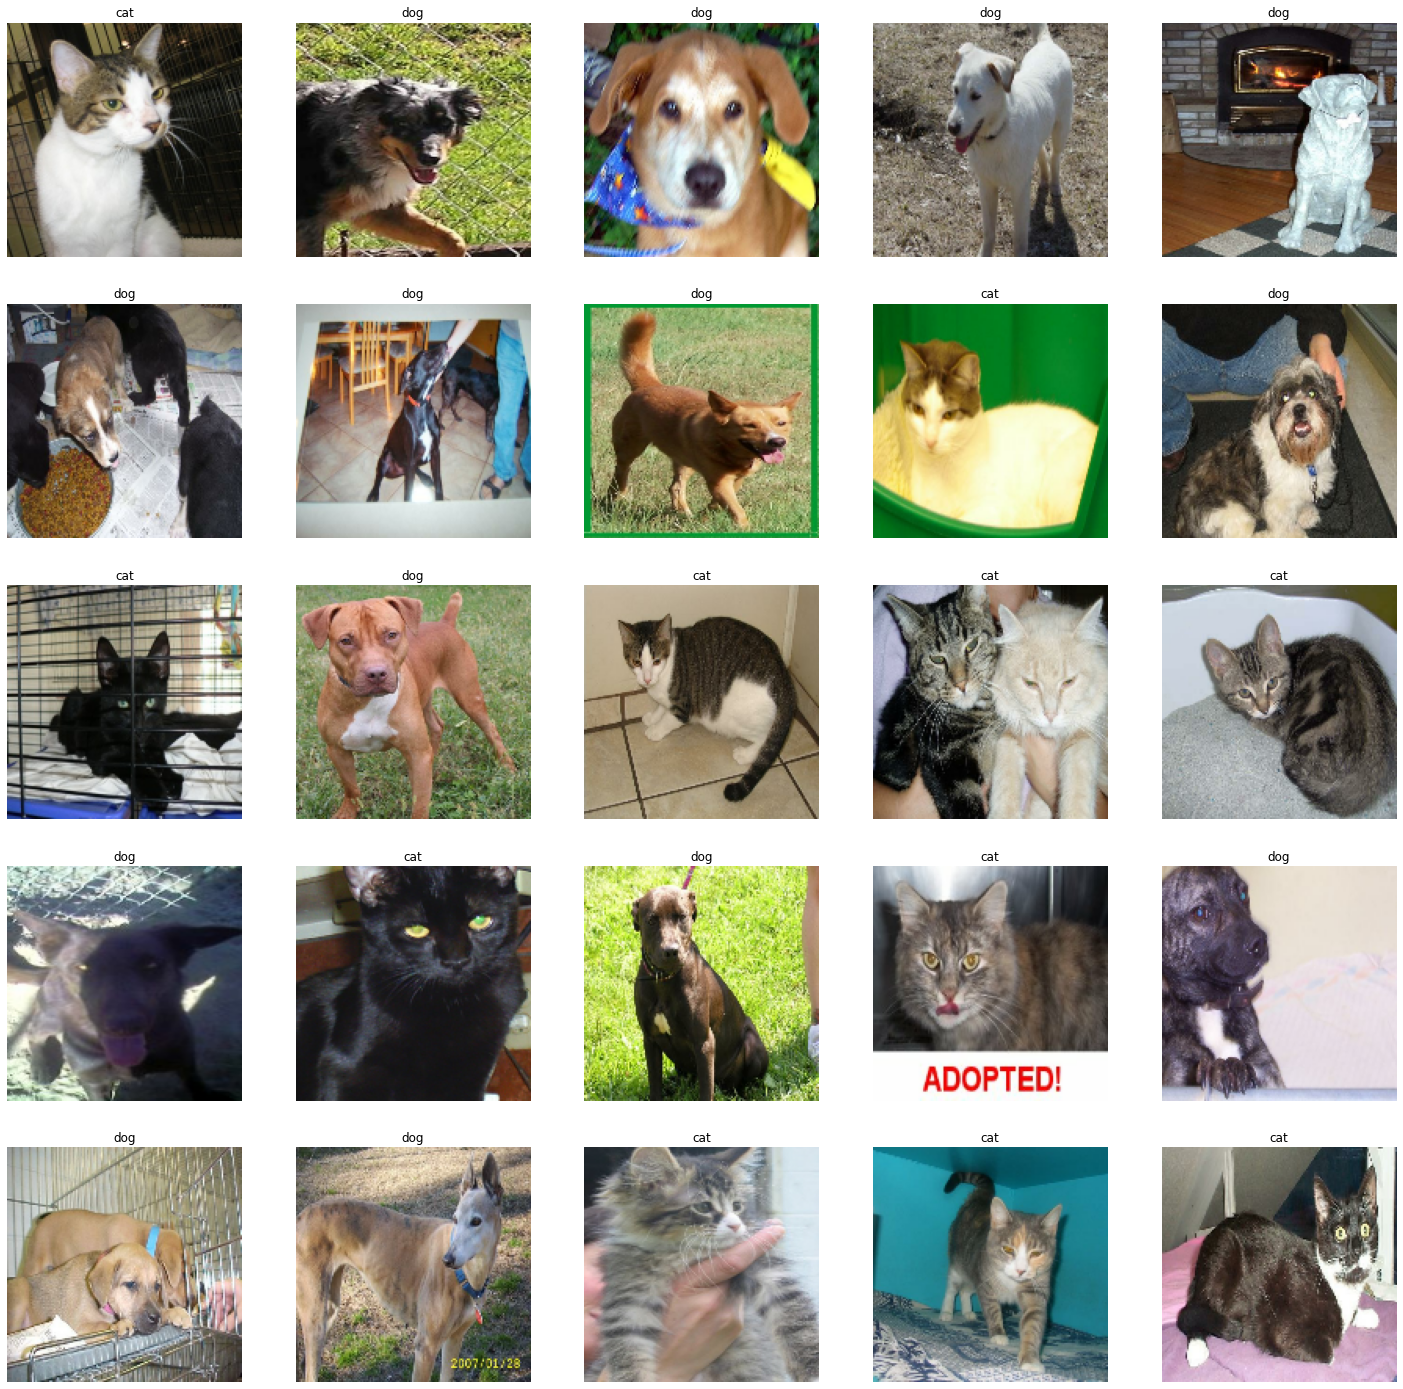

In [145]:
plt.figure(figsize=(25, 25))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [173]:
class_names=['cat','dog']
img = keras.preprocessing.image.load_img(
    "/Users/natalie/Downloads/iu-4.jpeg", target_size=(150,150)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array, steps=1)
#predictions = tf.convert_to_tensor(predictions)
predictions = tf.nn.sigmoid(predictions)
predictions1 = tf.where(predictions < 0.5, 0, 1)
print(class_names[predictions1.numpy()[0][0]])

cat


In [176]:
!pip install tensorflowjs

     |████████████████████████████████| 60 kB 625 kB/s eta 0:00:01
  Using cached PyInquirer-1.0.3.tar.gz (27 kB)
     |████████████████████████████████| 89 kB 956 kB/s eta 0:00:01
     |████████████████████████████████| 165.1 MB 1.0 MB/s eta 0:00:01   |▍                               | 1.7 MB 887 kB/s eta 0:03:05     |███████████████▏                | 78.4 MB 1.0 MB/s eta 0:01:25     |██████████████████████████████  | 154.7 MB 1.0 MB/s eta 0:00:11
     |████████████████████████████████| 15.1 MB 876 kB/s eta 0:00:01     |███████████████████████████     | 12.8 MB 1.0 MB/s eta 0:00:03
  Using cached prompt_toolkit-1.0.14-py3-none-any.whl (248 kB)
     |████████████████████████████████| 690 kB 889 kB/s eta 0:00:01
     |████████████████████████████████| 28.4 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 459 kB 886 kB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 1.0 MB/s eta 0:00:01


  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-py3-none-any.whl size=32849 sha256=00d1b7fe2a3ccbfc7e0eca76ede72743bb7c754797d0200ef91f6d382ba42704
  Stored in directory: /Users/natalie/Library/Caches/pip/wheels/89/3b/7b/8b3cc8ac47137eabaeb6937a3ff0d33e78a12e2ba1e3ad4ba1
  Created wheel for regex: filename=regex-2020.7.14-cp37-cp37m-macosx_10_15_x86_64.whl size=285134 sha256=2928730ad74c77fc788a07c1ab35e45a8555b6ab87d7807b3136a04205e63f4f
  Stored in directory: /Users/natalie/Library/Caches/pip/wheels/5b/68/ce/2508b5a5afc13bd96566c62d3ffebea7b401477c2ead3e8cc0
Successfully built PyInquirer regex
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.3.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 2.3.0 which is incompatible.
ERROR: jupyter-console 6.1.0 has requirement prompt-toolkit!=3.0.0,!=3.0.1,<3.1.0,>=2.0.0, but you'll have prompt-toolkit

In [177]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, './tfjs_ft_cat_dog')

/Users/natalie/python/virtualenvs/rcnn-keras/lib/python3.7/site-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


# Add prediction "decoder" directly into the model

In [181]:
base_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be normalized from (0, 255) to a range (-1., +1.), 
# the normalization layer does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(inputs)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode when we unfreeze the base 
# model for fine-tuning, so we make sure that the base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
normalization_4 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2049      
Total params: 20,863,536
Trainable params: 2,049
Non-trainable params: 20,861,487
___________________________________________

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)